# (1) Raw count quality
---
Michaël Pierrelée, Aix Marseille Univ, CNRS, IBDM, UMR7288, FRANCE - michael.pierrelee@univ-amu.fr

*Apache License 2.0*

---

The matrix of gene counts is assessed through distribution of prior counts ($log2(counts+1)$), MA-plot (diffence of counts minus the mean of counts for each gene between two replicates of the same condition) and PCA plot.

Before to be converted into prior counts, the genes are rounded to the closest integer and the genes without one count across samples are filtered out.

## Input
* `data/Trinity_genes.gene.counts.matrix`: raw counts from read quantification per gene by RSEM.
* `data/sample_files.tsv`: description of the experimental design.

## Output
* Figure `figures/distribution_counts.png`: distribution of prior counts for each replicate and the 4 conditions.
* Figure `figures/ma-plots.png`: MA-plots between replicates of a same condition.
* Figure `figures/pca-plot.png`: PCA plots of samples.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition as decomp

In [2]:
sns.set(style='white')

## Data
prior counts $y$ from raw counts of representative transcripts are $y=\log2{(x+1)}$

raw counts are filtered to keep only rows with > 10 counts

In [3]:
counts_file = '../data/Trinity_genes.gene.counts.matrix'
sample_files = '../data/sample_files.tsv'

In [4]:
raw_counts = pd.read_csv( counts_file, sep='\t', index_col=0 )

# filter
raw_counts = raw_counts[ (raw_counts.sum(axis=1) > 10) ]

# rename columns
samples = pd.read_csv( sample_files, sep='\t', index_col=2, header=None )
samples.columns = ['ID', 'official name', 'medium', 'phase']
df = pd.Series(samples.index, index = samples['ID'] )
raw_counts = raw_counts.rename( columns=df.to_dict() )

raw_counts = pd.read_csv( counts_file, sep='\t', index_col=0 )
raw_counts = round( raw_counts, 0 )
# filter
raw_counts = raw_counts[ (raw_counts.sum(axis=1) > 1) ]

priorcounts = raw_counts.apply( lambda x: np.log2(x+1) )

## Distribution of priorcounts

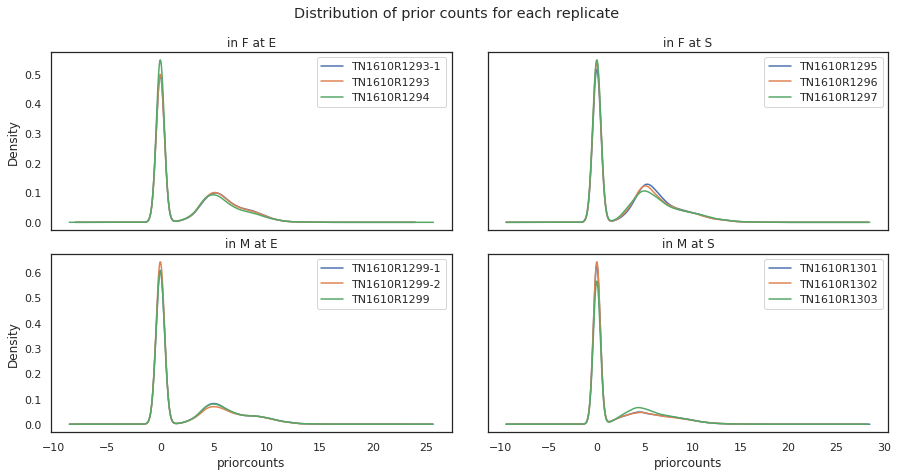

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.09, hspace=.13)
fig.suptitle('Distribution of prior counts for each replicate', x=.5, y=.97)

priorcounts.iloc[:, 0:3].plot.kde(title="in F at E", ax=axes[0,0], sharex = True, sharey = True)
priorcounts.iloc[:, 3:6].plot.kde(title="in F at S", ax=axes[0,1], sharex = True, sharey = True)
priorcounts.iloc[:, 6:9].plot.kde(title="in M at E", ax=axes[1,0], sharex = True, sharey = True)
priorcounts.iloc[:, 9:12].plot.kde(title="in M at S", ax=axes[1,1], sharex = True, sharey = True)

axes[1,0].set_xlabel("priorcounts")
axes[1,1].set_xlabel("priorcounts")

plt.savefig('../figures/distribution_counts.png', format='png', bbox_inches='tight')
plt.show()

## MA plots
reproducibility of replicates
* X-axis: A = average of priorcounts for both replicates
* Y-axis: M = difference of priorcounts between the two replicates

In [6]:
def plotMA(df, i, j, ax, title):
    cols = df.columns
    x, y = df[cols[i]], df[cols[j]]
    M = x - y
    A = (x + y) / 2
    MA = pd.DataFrame({"A":A, "M":M})

    sns.regplot(x="A", y="M", data=MA, ax=ax, lowess=True, line_kws={'color':'r'}, color="k")
    ax.axhline( 0 , color='green' ) # ideal value
    ax.set_title(title)

/home/pierrelee/miniconda3/envs/hs2_python_env/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


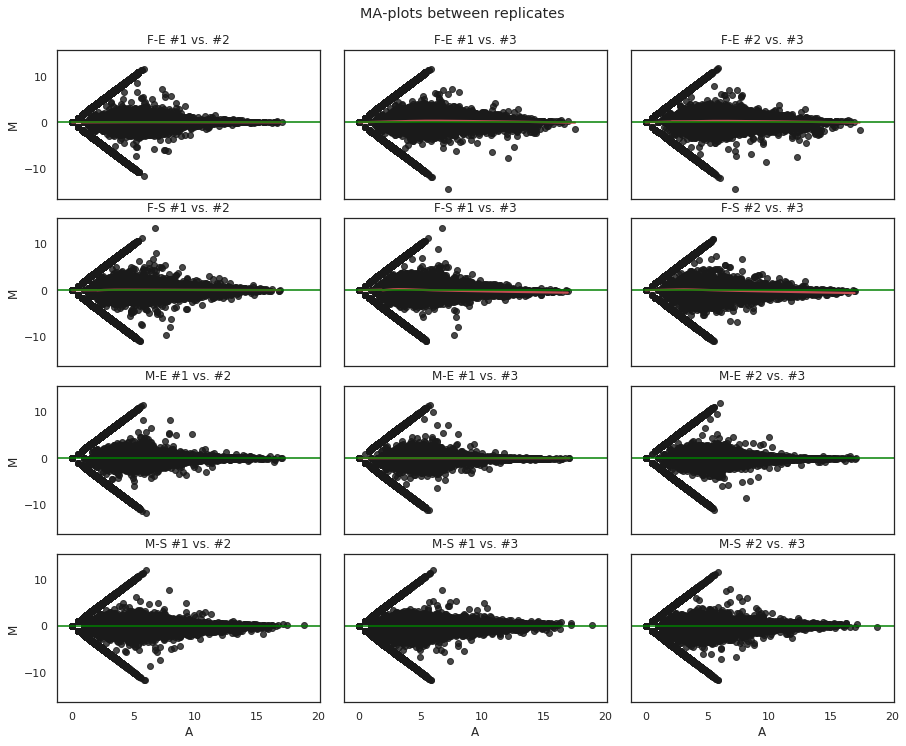

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12), sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.09, hspace=.13)
fig.suptitle('MA-plots between replicates', x=.5, y=.93)

grid = [ (i, j) for i in range(4) for j in range(3) ]
cond = ["F-E", "F-S", "M-E", "M-S"]
for a, b in enumerate(range(0, 12, 3)): # conditions
    for i, j in [(0, 1), (0, 2), (1, 2)]: # replicates
        name = '{} #{} vs. #{}'.format(cond[a], str(i+1), str(j+1))
        plotMA(priorcounts, b+i, b+j, axes[a][i+j-1], name )
        if j != 1 and a != 9: axes[a][i+j-1].set_ylabel('')
        if a != 3: axes[a][i+j-1].set_xlabel('') 
        
plt.savefig('../figures/ma-plots.png', format='png', bbox_inches='tight')
plt.show()

## PCA plot

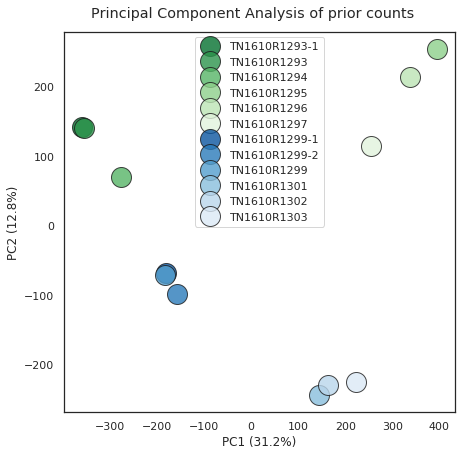

In [8]:
# decomposition into two components
pca = decomp.PCA(n_components=2)
principalComponents = pca.fit_transform( priorcounts.T.values )
principalDf = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2'], index=priorcounts.columns).T
explained_var = pca.explained_variance_ratio_ # variance for each principal components

# display
fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.suptitle('Principal Component Analysis of prior counts', x=.5, y=.93)
colors = sns.color_palette("Greens_r", 6).as_hex() + sns.color_palette("Blues_r", 6).as_hex()

for i, c in enumerate(principalDf):
    ax.plot( principalDf[c]["PC1"], principalDf[c]["PC2"], "o", label=c,
             color=colors[i], alpha=0.8, ms=20, markeredgecolor="k", mew=1 )

ax.legend(loc="best", frameon=True).get_frame().set_facecolor('white')
ax.set_xlabel( 'PC1 ({}%)'.format( str(round(explained_var[0]*100, 1)) ) )
ax.set_ylabel( 'PC2 ({}%)'.format( str(round(explained_var[1]*100, 1)) ) )
plt.savefig('../figures/pca-plot.png', format='png', bbox_inches='tight')
plt.show()